Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


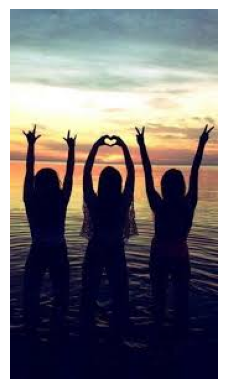

three people standing on top of a body of water


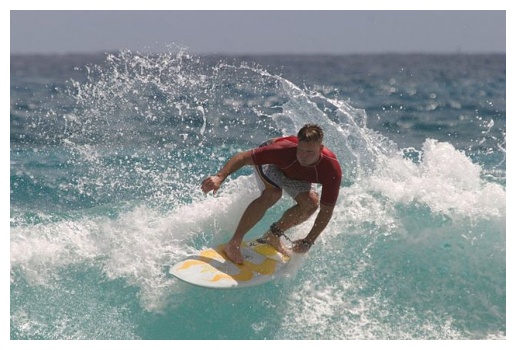

a man riding a wave on top of a surfboard


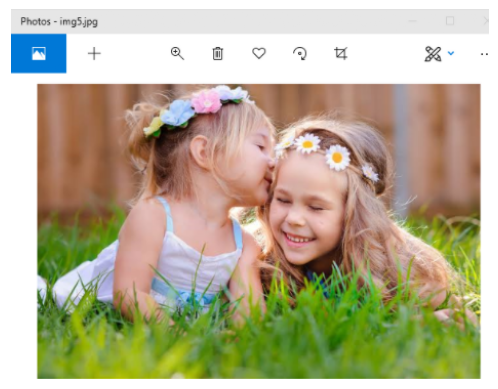

two little girls sitting next to each other on a field


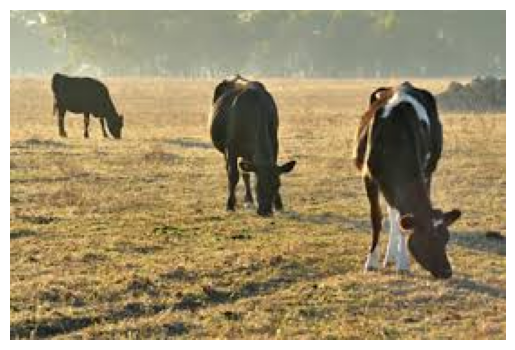

a herd of cattle grazing in a field


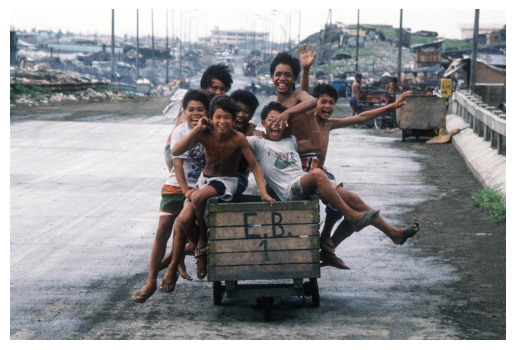

a man and a woman riding on a cart


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

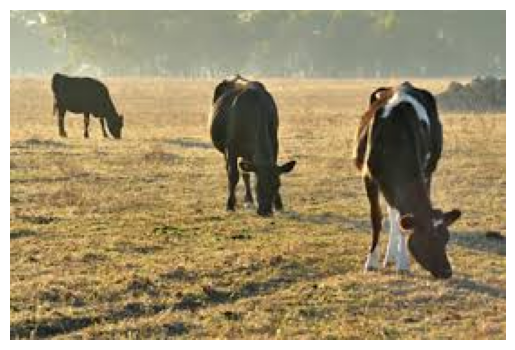

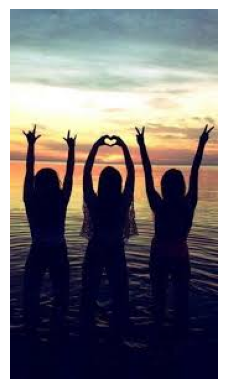

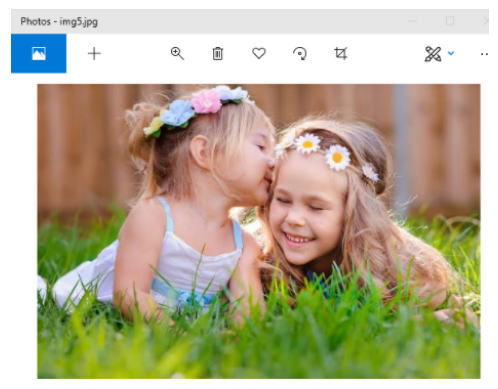

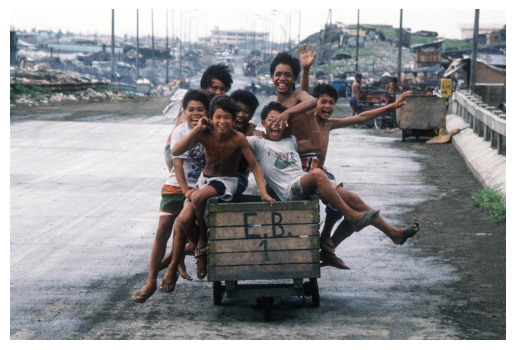

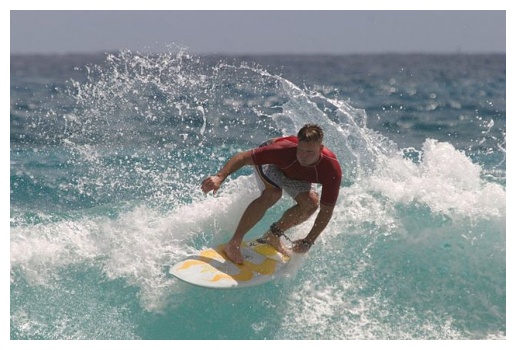

In [19]:
# Install necessary libraries including sentence-transformers
!pip install faiss-cpu
!pip install langchain
!pip install langchain-community
!pip install transformers
!pip install pillow
!pip install matplotlib
!pip install sentence-transformers

# Import necessary libraries
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
from google.colab import drive
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
import time

# Initialize model, feature extractor, and tokenizer
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict captions
def predict_step(image_paths):
    images = []
    for image_path in image_paths:
        i_image = Image.open(image_path)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")
        images.append(i_image)
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    output_ids = model.generate(pixel_values, max_length=16, num_beams=4)
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds

# Mount Google Drive
drive.mount('/content/drive')

# Path to images in Google Drive
my_drive_path = "/content/drive/MyDrive/pictures"
files = os.listdir(my_drive_path)
images = [file for file in files if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jfif")]

# Generate captions for images
img_caption = {}
for image in images:
    image_path = os.path.join(my_drive_path, image)
    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    plt.show()
    caption = predict_step([image_path])[0]
    img_caption[image_path] = caption
    print(caption)

# Create documents from image paths and captions
documents = [Document(page_content=caption, metadata={"image_path": image_path}) for image_path, caption in img_caption.items()]

# Create an embedding function
embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Function to create embeddings with retries
def create_embeddings_with_retries(documents, max_retries=3):
    for attempt in range(max_retries):
        try:
            return FAISS.from_documents(documents, embedding=embedding_function)
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
            else:
                raise

# Create a vector store
vector_store = create_embeddings_with_retries(documents)

# Search for images using a query
query = "A picture of a cat"
similar_images = vector_store.similarity_search(query, k=5)

# Display the similar images
for doc in similar_images:
    image_path = doc.metadata['image_path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
